In [1]:
from time import time

In [2]:
tic = time()

In [3]:
from ship_routing import Trajectory
from ship_routing.currents import load_currents_time_average
from ship_routing.mc import move_random_node

In [4]:
import numpy as np
import tqdm
import pandas as pd
import shapely
import warnings
from random import choice
from functools import reduce

In [5]:
from matplotlib import pyplot as plt
import cartopy

In [6]:
# parameters
resolution = 4_000_000
perturbation = 4_000_000
perturbation_numsteps = 1
duration = 30 * 24 * 3600
random_seed = 1234
pop_res_factor = 4
max_population_size = 1000
num_updates_per_res_fac = 1

In [7]:
np.random.seed(random_seed)

In [8]:
currents = load_currents_time_average(
    "data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_1deg_5day.nc"
)
currents["speed"] = (currents.to_array() ** 2).sum("variable") ** 0.5
currents = currents.where(currents.speed > 0)
currents = currents.compute()

In [9]:
traj_ref = Trajectory(
    lon=[-80.1, -4.1],  # Miami to English Channel
    lat=[25.8, 49.5],
    duration_seconds=duration,
).refine(new_dist=resolution)

In [10]:
def calc_cost(pop):
    return [m.estimate_cost_through(currents) for m in pop]

In [11]:
def perturb_replicate(pop, ratio_best_all=8):
    pop2 = []
    cost = []
    for n in range(len(population)):
        m = pop[n].copy()
        for npert in range(perturbation_numsteps):
            for ntry in range(10):
                _m = move_random_node(
                    trajectory=m, max_dist_meters=perturbation
                ).homogenize()
                _cost = _m.estimate_cost_through(currents)
                if not np.isnan(_cost):
                    m = _m
                    c = _cost
                    break
        pop2.append(m)
        cost.append(c)
    best_10perc = [
        pop2[_n].copy()
        for _n in pd.Series(cost).sort_values().index[: int(len(population) // 10)]
    ]
    best_80perc = [
        pop2[_n].copy()
        for _n in pd.Series(cost).sort_values().index[: int(8 * len(population) // 10)]
    ]
    pool = ratio_best_all * len(pop2) * best_10perc + best_80perc
    return [choice(pool).copy() for n in range(len(population))]

In [12]:
population_size = pop_res_factor * len(traj_ref)
population_size = min(population_size, max_population_size)

In [13]:
population = [traj_ref.copy() for npop in tqdm.tqdm(range(population_size))]
cost = [
    calc_cost(pop=population[:1]) * population_size,
]

100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 56299.38it/s]


In [14]:
# warmup (accept all of the best 80 %)
for nevol in tqdm.tqdm(range(3 * num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population, ratio_best_all=0)

100%|███████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 26.98it/s]


In [15]:
for nevol in tqdm.tqdm(range(num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population)
    cost.append(calc_cost(population))

100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.61it/s]


In [16]:
population_0 = [m.copy() for m in population]

In [17]:
resolution /= 2
perturbation /= 2
population = [m.copy().refine(new_dist=resolution) for m in population]
population_size = pop_res_factor * max([len(m) for m in population])
population_size = min(population_size, max_population_size)
population = [choice(population).copy() for npop in range(population_size)]

In [18]:
for nevol in tqdm.tqdm(range(num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population)
    cost.append(calc_cost(population))

100%|███████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]


In [19]:
population_1 = [m.copy() for m in population]

In [20]:
resolution /= 2
perturbation /= 2
population = [m.copy().refine(new_dist=resolution) for m in population]
population_size = pop_res_factor * max([len(m) for m in population])
population_size = min(population_size, max_population_size)
population = [choice(population).copy() for npop in range(population_size)]

In [21]:
for nevol in tqdm.tqdm(range(num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population)
    cost.append(calc_cost(population))

100%|███████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.29it/s]


In [22]:
population_2 = [m.copy() for m in population]

In [23]:
resolution /= 2
perturbation /= 2
population = [m.copy().refine(new_dist=resolution) for m in population]
population_size = pop_res_factor * max([len(m) for m in population])
population_size = min(population_size, max_population_size)
population = [choice(population).copy() for npop in range(population_size)]

In [24]:
for nevol in tqdm.tqdm(range(num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population)
    cost.append(calc_cost(population))

100%|█████████████████████████████████████████████████████████████████| 17/17 [00:53<00:00,  3.12s/it]


In [25]:
population_3 = [m.copy() for m in population]

In [26]:
resolution /= 2
perturbation /= 2
population = [m.copy().refine(new_dist=resolution) for m in population]
population_size = pop_res_factor * max([len(m) for m in population])
population_size = min(population_size, max_population_size)
population = [choice(population).copy() for npop in range(population_size)]

In [27]:
for nevol in tqdm.tqdm(range(num_updates_per_res_fac * len(population[0]))):
    population = perturb_replicate(pop=population, ratio_best_all=4)
    cost.append(calc_cost(population))

100%|█████████████████████████████████████████████████████████████████| 33/33 [08:26<00:00, 15.35s/it]


In [28]:
population_4 = [m.copy() for m in population]

In [29]:
print(len(population))

132


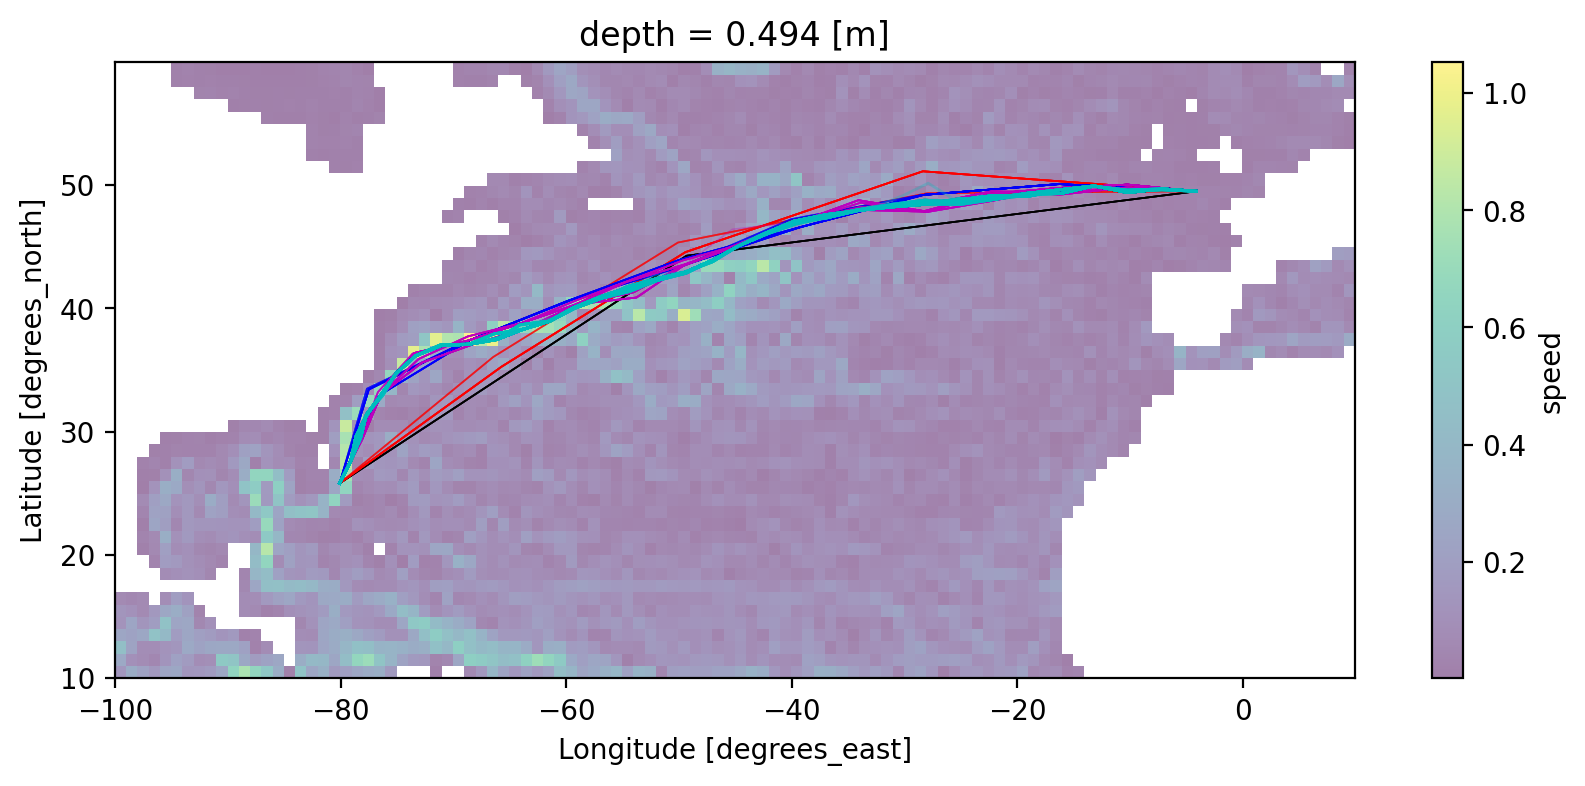

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
fig.set_dpi(200)

currents.sel(lon=slice(-100, 10), lat=slice(10, 60)).speed.plot(alpha=0.5, ax=ax)
for m in population_0:
    ax.plot(*m.line_string.xy, "k-", linewidth=0.6, alpha=0.3)
for m in population_1:
    ax.plot(*m.line_string.xy, "r-", linewidth=0.6, alpha=0.3)
for m in population_2:
    ax.plot(*m.line_string.xy, "b-", linewidth=0.6, alpha=0.3)
for m in population_3:
    ax.plot(*m.line_string.xy, "m-", linewidth=0.6, alpha=0.3)
for m in population_4:
    ax.plot(*m.line_string.xy, "c-", linewidth=1, alpha=0.3)

<Axes: >

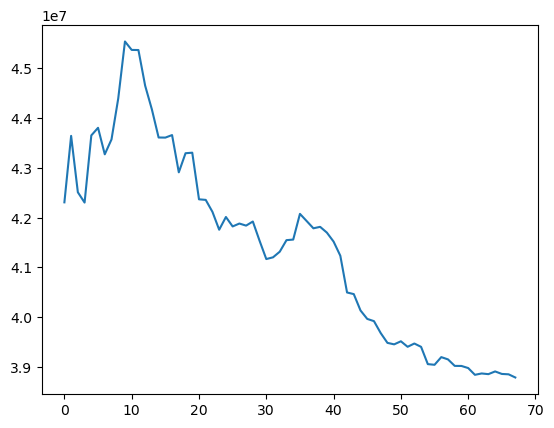

In [31]:
(pd.DataFrame.from_records(cost).T.quantile(0.2)).plot()

In [32]:
print(time() - tic, "seconds")

570.2537779808044 seconds
